<a href="https://colab.research.google.com/github/Congyan111/STATS507/blob/main/gpt2_finetuning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPT-2 Ancient-Style Lyric Generation Project
Project Objective
Fine-tune a GPT-2 model to generate coherent and stylistically consistent ancient-style Chinese lyrics.

Model & Dataset

Pretrained Model: uer/gpt2-chinese-lyric

Dataset: chinese_poems.txt (local plain text file)

Tokenizer Type: BERT-style WordPiece (google_zh_vocab.txt)




In [1]:

%pip install -q datasets transformers accelerate torch matplotlib pandas numpy


In [2]:

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0+cu126
CUDA: True
GPU device: NVIDIA L4


In [3]:
from datasets import load_dataset

#load dataset
ds = load_dataset("congyanyin0623/chinese_poems.txt", split="train")

raw_lines = [item["text"] for item in ds]
print("number of lines of raw data:", len(raw_lines))

# random show raw data
import random
for i in random.sample(raw_lines, 3):
    print("\n raw data sample:", i)



chinese_poems.txt:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/304752 [00:00<?, ? examples/s]

number of lines of raw data: 304752

 raw data sample: 天马从西极,云鹏起北溟.黍离怀故国,风景过新亭.文物衣冠会,山河庙社灵.独无中上策,一耸汉臣听.

 raw data sample: 闭门读丧礼,荒庭蓬藋深.愁云聚陇首,悲风吹棘心.隣里昨甚忧,哭踊恐不任.近除二月禫,初御五日琴.虽复瘦栾栾,众语喜见今.谅其念遗体,保此躯千金.顾无疡可沐,发脱未胜簪.稍当理衣冠,结绶且正襟.渠家符玺郎,实冠翰墨林.世业乏润色,诏书行访寻.䌷绎须史迁,校雠得刘歆.再编中兴诗,更载庭燎箴.暇时侍君侧,祈招诵愔愔.

 raw data sample: 身自无安处,升州更广州.逐教子方去,死到了翁休.凤至虞廷喜,麟亡鲁野愁.忧时兼悼友,白却九分头.


In [4]:
import re

# data cleaning
def is_dirty_line(line):
    # include 囗 or Unicode Replacement Character �
    if "囗" in line or "�" in line:
        return True

    # Remove Rare Characters Beyond the Unicode BMP CJK Range (e.g., Extensions B/C/D/E)
    for ch in line:
        if ord(ch) > 0xFFFF:
            return True

    return False

# Remove Parenthetical Annotations
def remove_annotations(line):
    patterns = [
        r'（.*?）', r'\(.*?\)', r'【.*?】', r'〔.*?〕',
        r'《.*?》', r'「.*?」', r'『.*?』', r'〖.*?〗'
    ]
    for p in patterns:
        line = re.sub(p, '', line)
    return line.strip()

# Remove Consecutive Garbage Symbols
def remove_garbage_symbols(line):
    line = re.sub(r'[.,;:·…~!@#$%^*+=<>/\\|（）()［］\[\]{}]{2,}', '', line)
    return line.strip()

# clean each row
def clean_line(line):
    if not line.strip():
        return None

    line = remove_annotations(line)
    line = remove_garbage_symbols(line)

    # clean too short row
    if len(line) < 4:
        return None

    if is_dirty_line(line):
        return None

    return line


In [5]:
clean_poems = []
removed = 0

for line in raw_lines:
    cleaned = clean_line(line)
    if cleaned:
        clean_poems.append(cleaned)
    else:
        removed += 1

print(f"\n number of rows after cleanning: {len(clean_poems)}")
print(f"removed rows: {removed}")



 number of rows after cleanning: 295753
removed rows: 8999


In [6]:
print("\n=== Comparison Before and After Cleaning (Random 5 Lines) ===")
for raw in random.sample(raw_lines, 5):
    clean = clean_line(raw)
    print("\n row:", raw)
    print("clean:", clean if clean else "（removed）")



=== Comparison Before and After Cleaning (Random 5 Lines) ===

 row: 村陋垣屋颓,岁晚风雨横.泥涂绝还往,飧粥养衰病.药囊杂书卷,白发满清镜.一榻卧兼旬,不践墙下径.乌鹊忽报晴,霜重节候正.厌供冻砚愁,颇动蜡屐兴.山楹快远眺,松吹惬幽听.地瘦药苖稀,叶脱木枝劲.东村未为远,脚力不济胜.三叹入荆扉,跏趺学僧定.
clean: 村陋垣屋颓,岁晚风雨横.泥涂绝还往,飧粥养衰病.药囊杂书卷,白发满清镜.一榻卧兼旬,不践墙下径.乌鹊忽报晴,霜重节候正.厌供冻砚愁,颇动蜡屐兴.山楹快远眺,松吹惬幽听.地瘦药苖稀,叶脱木枝劲.东村未为远,脚力不济胜.三叹入荆扉,跏趺学僧定.

 row: 蕴玉含晖一水间,碧光炯炯照人寒.却疑洗出荆山璞,若有瑕疵试指看.
clean: 蕴玉含晖一水间,碧光炯炯照人寒.却疑洗出荆山璞,若有瑕疵试指看.

 row: 御礼征奇策,人心注盛时.从来留振滞,只待济临危.
clean: 御礼征奇策,人心注盛时.从来留振滞,只待济临危.

 row: 供帐荣归一日同,故乡增重汉朝空.二疎事莫征图画,西陌东阡看两翁.
clean: 供帐荣归一日同,故乡增重汉朝空.二疎事莫征图画,西陌东阡看两翁.

 row: 逆鼻清香小不分,冰肌一洗瘴江昏.岭头未负春消息,恐是梅花欲返魂.
clean: 逆鼻清香小不分,冰肌一洗瘴江昏.岭头未负春消息,恐是梅花欲返魂.


In [7]:
from datasets import Dataset, DatasetDict

dataset_clean = Dataset.from_list([{"text": p} for p in clean_poems])
dataset_clean = dataset_clean.train_test_split(test_size=0.2, seed=42)

dataset_clean = DatasetDict({
    "train": dataset_clean["train"],
    "validation": dataset_clean["test"]
})

print(dataset_clean)
print("train size:", len(dataset_clean["train"]))
print("validation size:", len(dataset_clean["validation"]))


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 236602
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 59151
    })
})
train size: 236602
validation size: 59151


datasets stats:
total : 236602
mean: 59.32
median: 48.00
min: 4
max: 2352

Saved: 'poem_length_distribution.png'


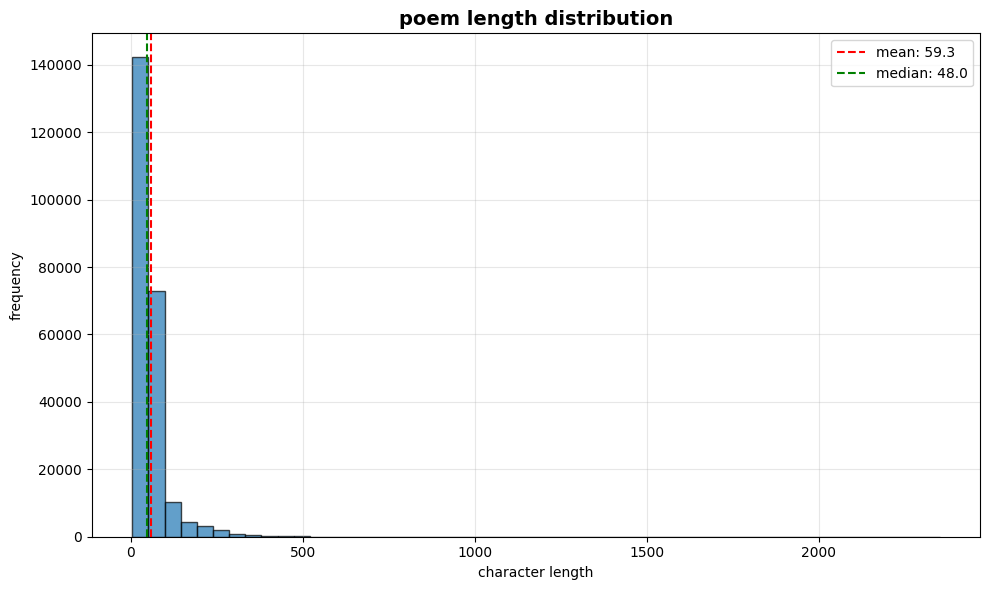

In [8]:

lengths = [len(x["text"]) for x in dataset_clean["train"]]

print("datasets stats:")
print(f"total : {len(dataset_clean['train'])}")
print(f"mean: {np.mean(lengths):.2f}")
print(f"median: {np.median(lengths):.2f}")
print(f"min: {np.min(lengths)}")
print(f"max: {np.max(lengths)}")

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title("poem length distribution", fontsize=14, fontweight='bold')
plt.xlabel("character length")
plt.ylabel("frequency")

plt.axvline(np.mean(lengths), color='red', linestyle='--',
            label=f'mean: {np.mean(lengths):.1f}')
plt.axvline(np.median(lengths), color='green', linestyle='--',
            label=f'median: {np.median(lengths):.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('poem_length_distribution.png', dpi=300, bbox_inches='tight')

print("\nSaved: 'poem_length_distribution.png'")
plt.show()



In [9]:
# Load tokenizer
# Note: Use the BERT-style WordPiece tokenizer included with the model (google_zh_vocab.txt)
# Not SentencePiece
tokenizer = AutoTokenizer.from_pretrained("uer/gpt2-chinese-lyric", trust_remote_code=True)

tokenizer.eos_token = tokenizer.sep_token

# ★★★ padding [sep]
tokenizer.pad_token = tokenizer.eos_token

print(f"vocab size: {len(tokenizer)}")
print(f"Tokenizer class: {type(tokenizer).__name__}")
print(f"Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")

# testing tokenizer
test_text = dataset_clean["train"][0]["text"]
tokens = tokenizer(test_text, return_tensors="pt")
print(f"\n test sample: {test_text[:50]}...")
print(f"Token number: {tokens['input_ids'].shape[1]}")
print(f"top 10 tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][:10])}")


tokenizer_config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

vocab size: 21128
Tokenizer class: BertTokenizerFast
Pad token: [SEP] (ID: 102)
EOS token: [SEP] (ID: 102)

 test sample: 春过湘江渡,真观八景图.云藏岳麓寺,江入洞庭湖.晴日花争发,丰年酒易沽.长沙十万户,游女似京都....
Token number: 50
top 10 tokens: ['[CLS]', '春', '过', '湘', '江', '渡', ',', '真', '观', '八']


In [10]:

# Correct data preprocessing function
# Use tokenizer to automatically generate input_ids and attention_mask
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# implemention
tokenized_ds = dataset_clean.map(
    preprocess,
    batched=True,
    remove_columns=dataset_clean["train"].column_names
)

print(f"\nTokenization finished！")
print(f"train size: {len(tokenized_ds['train'])}")
print(f"validation size: {len(tokenized_ds['validation'])}")
print(f"Training Set Fields: {list(tokenized_ds['train'][0].keys())}")

# show first sample
sample = tokenized_ds['train'][0]
print(f"\n first sample detail:")
print(f"  input_ids length: {len(sample['input_ids'])}")
print(f"  attention_mask length: {len(sample['attention_mask'])}")
print(f"  number of valid: {sum(sample['attention_mask'])}")
print(f"  top 10 input_ids: {sample['input_ids'][:10]}")
print(f"  top 10 attention_mask: {sample['attention_mask'][:10]}")


Map:   0%|          | 0/236602 [00:00<?, ? examples/s]

Map:   0%|          | 0/59151 [00:00<?, ? examples/s]


Tokenization finished！
train size: 236602
validation size: 59151
Training Set Fields: ['input_ids', 'token_type_ids', 'attention_mask']

 first sample detail:
  input_ids length: 128
  attention_mask length: 128
  number of valid: 50
  top 10 input_ids: [101, 3217, 6814, 3960, 3736, 3941, 117, 4696, 6225, 1061]
  top 10 attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
# Create Data Collator
# GPT2 is an autoregressive model, use mlm=False (not a masked language model)
# DataCollatorForLanguageModeling will automatically:
# 1. Shift input_ids right by one position to use as labels
# 2. Set the label at the first position to -100 (ignore loss)
# 3. Set labels at padding positions to -100 (ignore padding loss)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # False（causal LM）
)

print("DataCollator finished！")

# testing
print("\n test DataCollator:")
test_batch = [tokenized_ds['train'][i] for i in range(2)]
collated = data_collator(test_batch)
print(f"Batch keys: {collated.keys()}")
print(f"input_ids shape: {collated['input_ids'].shape}")
print(f"attention_mask shape: {collated['attention_mask'].shape}")
print(f"labels shape: {collated['labels'].shape}")
print(f"number of -100 in labels: {(collated['labels'] == -100).sum().item()}")
print(f"number of valid tokens in labels : {(collated['labels'] != -100).sum().item()}")


DataCollator finished！

 test DataCollator:
Batch keys: KeysView({'input_ids': tensor([[ 101, 3217, 6814, 3960, 3736, 3941,  117, 4696, 6225, 1061, 3250, 1745,
          119,  756, 5966, 2277, 7926, 2191,  117, 3736, 1057, 3822, 2431, 3959,
          119, 3252, 3189, 5709,  751, 1355,  117,  705, 2399, 6983, 3211, 3782,
          119, 7270, 3763, 1282,  674, 2787,  117, 3952, 1957,  849,  776, 6963,
          119,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102],
        [ 101, 1921, 6804, 2145, 7027,  758, 6816, 11

In [12]:
# load model
model = AutoModelForCausalLM.from_pretrained("uer/gpt2-chinese-lyric", trust_remote_code=True)

# set pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print(f"model type: {type(model)}")
print(f"number of model param: {sum(p.numel() for p in model.parameters()):,}")
print(f"Pad token ID: {model.config.pad_token_id}")


pytorch_model.bin:   0%|          | 0.00/421M [00:00<?, ?B/s]

model type: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
number of model param: 102,068,736
Pad token ID: 102


In [13]:
# set model superparam
output_dir = "./gpt2-poem"
logging_dir = "./logs"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    warmup_steps=100,
    logging_dir=logging_dir,
    logging_steps=50,

    eval_strategy="steps",
    eval_steps=2000,

    save_strategy="steps",
    save_steps=2000,

    save_total_limit=3,
    load_best_model_at_end=True,

    fp16=True,
    report_to="tensorboard",
)


In [ ]:
# trainner
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"] if "validation" in tokenized_ds else None,
    data_collator=data_collator
)



trainer.train()

print("\n finished trained！")


model.safetensors:   0%|          | 0.00/421M [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


In [ ]:
# # save model
model_save_path = "gpt2-poem-best"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)


# load model
fine_tuned_model = AutoModelForCausalLM.from_pretrained(model_save_path, trust_remote_code=True)
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(model_save_path, trust_remote_code=True)

fine_tuned_tokenizer.eos_token = fine_tuned_tokenizer.sep_token

# pad_token = eos_token
fine_tuned_tokenizer.pad_token = fine_tuned_tokenizer.eos_token
fine_tuned_model.config.pad_token_id = fine_tuned_tokenizer.pad_token_id

print(f"Pad token: {fine_tuned_tokenizer.pad_token} (ID: {fine_tuned_tokenizer.pad_token_id})")
print(f"EOS token: {fine_tuned_tokenizer.eos_token} (ID: {fine_tuned_tokenizer.eos_token_id})")


Inference (Generating Ancient Poetry)
Supports multiple decoding strategies:

greedy (greedy decoding)

beam search (beam search)

top-k (Top-k sampling)

top-p (Top-p nucleus sampling)

top-p + temperature (combined sampling)

repetition_penalty (repetition penalty)

In [ ]:
def generate_text(prompt, model=None, tokenizer=None, max_length=80, **kwargs):

    if model is None:
        model = fine_tuned_model
    if tokenizer is None:
        tokenizer = fine_tuned_tokenizer


    inputs = tokenizer(prompt, return_tensors="pt")


    device = next(model.parameters()).device
    input_ids = inputs['input_ids'].to(device)


    gen_kwargs = {
        'max_length': max_length,
        'pad_token_id': tokenizer.eos_token_id,
        'eos_token_id': tokenizer.eos_token_id,
    }
    gen_kwargs.update(kwargs)


    with torch.no_grad():
        outputs = model.generate(input_ids, **gen_kwargs)


    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

test_prompt = "春风"
result = generate_text(test_prompt, do_sample=True, top_p=0.9, temperature=0.7)
print(f"prompt: {test_prompt}")
print(f"result: {result}")


In [ ]:
# promot
test_prompts = ["春风", "明月", "山水", "江南"]

print("=" * 80)
print("comparison")
print("=" * 80)

# Greedy
print("\n【Greedy】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=False)
    print(f"\prompt: {prompt}")
    print(f"result: {generated}")
    print()


In [ ]:
# Beam Search
print("\n【Beam Search】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, num_beams=5, do_sample=False)
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()


In [ ]:
# Top-k=50
print("\n【Top-k=50】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=True, top_k=50, temperature=1.0)
    print(f"\n promot: {prompt}")
    print(f" result: {generated}")
    print()


In [ ]:
# Top-p=0.9
print("\n【Top-p=0.9】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=True, top_p=0.9, temperature=1.0)
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()


In [ ]:
# Top-p=0.9 + temperature=0.7
print("\n【Top-p=0.9 + temperature=0.7】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=True, top_p=0.9, temperature=0.7)
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()


In [ ]:

print("\n【Top-p=0.9 + temperature=0.7 + repetition_penalty=1.2】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(
        prompt,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.2
    )
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()


In [ ]:
# evaluate
strategies = {
    'Greedy': {'do_sample': False},
    'Beam Search': {'num_beams': 5, 'do_sample': False},
    'Top-k=50': {'do_sample': True, 'top_k': 50, 'temperature': 1.0},
    'Top-p=0.9': {'do_sample': True, 'top_p': 0.9, 'temperature': 1.0},
    'Top-p=0.9+Temp=0.7': {'do_sample': True, 'top_p': 0.9, 'temperature': 0.7},
}

# result
all_results = {}
for strategy_name, params in strategies.items():
    print(f"\n stratigy: {strategy_name}")
    results = []
    for prompt in test_prompts:
        generated = generate_text(prompt, **params)
        generated_only = generated[len(prompt):].strip()
        results.append({
            'prompt': prompt,
            'generated': generated,
            'generated_only': generated_only,
            'length': len(generated_only),
            'line_count': generated_only.count('\n')
        })
    all_results[strategy_name] = results



In [ ]:
comparison_data = []
for strategy_name, results in all_results.items():
    for result in results:
        comparison_data.append({
            'stratigy': strategy_name,
            'prompt': result['prompt'],
            'length': result['length'],
            'number of row': result['line_count'],
            'result': result['generated_only'][:60] + '...' if len(result['generated_only']) > 60 else result['generated_only']
        })

df_comparison = pd.DataFrame(comparison_data)
print("\n comparison")
print(df_comparison.to_string(index=False))


In [ ]:
# Visualize the generated text lengths under different strategies
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average generated length
avg_lengths = df_comparison.groupby('Decoding Strategy')['Generated Length'].mean().sort_values()
axes[0].barh(range(len(avg_lengths)), avg_lengths.values)
axes[0].set_yticks(range(len(avg_lengths)))
axes[0].set_yticklabels(avg_lengths.index)
axes[0].set_xlabel('Average Generated Length (characters)')
axes[0].set_title('Average Generated Length by Decoding Strategy', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Average number of lines
avg_lines = df_comparison.groupby('Decoding Strategy')['Line Count'].mean().sort_values()
axes[1].barh(range(len(avg_lines)), avg_lines.values, color='orange')
axes[1].set_yticks(range(len(avg_lines)))
axes[1].set_yticklabels(avg_lines.index)
axes[1].set_xlabel('Average Number of Lines')
axes[1].set_title('Average Line Count by Decoding Strategy', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('decoding_strategies_comparison.png', dpi=300, bbox_inches='tight')
print("Decoding strategies comparison chart saved as 'decoding_strategies_comparison.png'")
plt.show()
